<a href="https://colab.research.google.com/github/saivishwanathgoud/DS_Marketing/blob/master/Propensity_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

#Label engineering
import composeml as cp

#Feature engineering
import featuretools as ft


plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('float_format', '{:f}'.format)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Although there are many datasets, for EDA I'll take 3 datasets:
1. Transactions 
2. Items 
3. Customers

In [2]:
transactions = pd.read_csv('customer_transaction_data.csv', parse_dates=[0])
transactions.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000
1,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000
2,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000
3,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000
4,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000


In [3]:
#products 
items = pd.read_csv('item_data.csv')
items.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [4]:
#customers
customers = pd.read_csv('customer_demographics.csv')
customers.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [5]:
print('Data is from {} and to {}'.format(transactions.date.min().date(), transactions.date.max().date()))
print('There is total {} customers'.format(transactions.customer_id.nunique()))

Data is from 2012-01-02 and to 2013-07-03
There is total 1582 customers


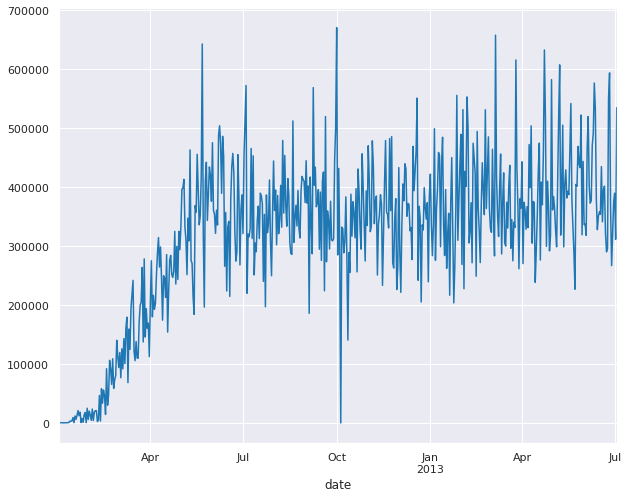

In [6]:
#plotting total sales 
plt.figure(figsize= (10,8))
transactions.groupby('date')['quantity'].sum().plot()
plt.show()

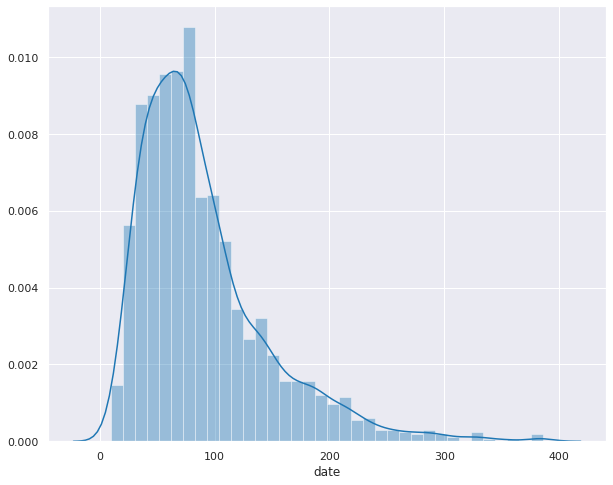

In [7]:
#On how many days do people make purchases?
plt.figure(figsize= (10,8))
sns.distplot(transactions.groupby(['customer_id'])['date'].nunique())
plt.show()

There are 19 unique year months
count   1582.000000
mean      15.675727
std        2.251522
min        4.000000
25%       15.000000
50%       16.000000
75%       17.000000
max       19.000000
Name: year_month, dtype: float64


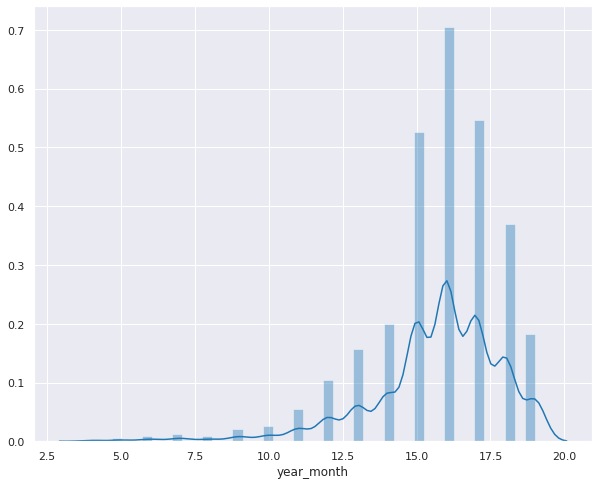

In [8]:
#In how many unique months do people make purchases?
transactions['year_month'] = pd.to_datetime(transactions['date'].apply(lambda x: x.strftime('%B-%Y')))
print('There are {} unique year months'.format(transactions['year_month'].nunique()))

print(transactions.groupby(['customer_id'])['year_month'].nunique().describe())
plt.figure(figsize= (10,8))
sns.distplot(transactions.groupby(['customer_id'])['year_month'].nunique())
plt.show()

In [10]:
#how many transactions customers have in a year month 
cust_transactions = transactions.groupby(['customer_id', 'year_month'])['quantity'].sum()
cust_transactions.describe()

count    24799.000000
mean      6978.999839
std      16192.200044
min          1.000000
25%         27.000000
50%         70.000000
75%       5814.000000
max     255639.000000
Name: quantity, dtype: float64

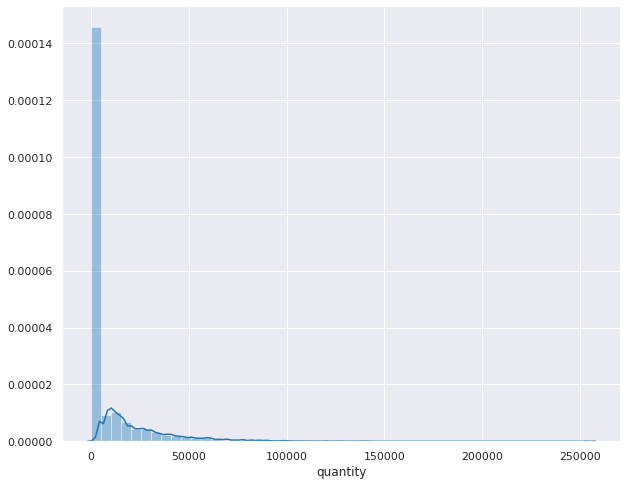

In [12]:
plt.figure(figsize= (10,8))
sns.distplot(cust_transactions)

##Feature Engineering##

From the above graphs, we see most of customers purchase every month with a median of 70 items. So instead of predicting whether a customer will buy in the next week, **I'll be predicting whether a customer will buy a lot in the next week**.

**Label**

In [13]:
#group by id and date
transformed_data = pd.DataFrame(transactions.groupby(['customer_id', 'date'])['quantity', 'selling_price'].sum()).reset_index()
transformed_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,customer_id,date,quantity,selling_price
0,1,2012-02-21,31,2603.450000
1,1,2012-03-08,13,1431.200000
2,1,2012-03-29,9,691.730000
3,1,2012-04-04,28,1913.500000
4,1,2012-04-11,17,1702.280000


In [14]:
#How many items do people purchase weekly?
weekly_purchases = transformed_data.groupby(['customer_id', pd.Grouper(key='date', freq='W-MON')])['quantity'].sum().reset_index().sort_values('date')
weekly_purchases['quantity'].describe()

count    75552.000000
mean      2290.769497
std       6036.070553
min          1.000000
25%          8.000000
50%         20.000000
75%         49.000000
max     122593.000000
Name: quantity, dtype: float64

Based on the table above, the cut-off for super customers will be 49 items. Those who buy more than 49 items in the next week are classified as *super-customers* and those who buy less are classified as regular customers

In [15]:
#Function to determine super customers (1 -Yes and 0 - No)
def is_super(df): 
  total = df['quantity'].sum()
  if total > 49: 
    return 1 
  else: 
    return 0

In [16]:
%%time

#creating label maker instance https://compose.featurelabs.com/en/latest/index.html

label_maker = cp.LabelMaker(
    target_entity="customer_id", #for whom to create labels?
    time_index="date",
    labeling_function=is_super, #scoring function above
    window_size="W" #weekly window
)

#Creating labels
lt = label_maker.search(
    transactions.sort_values('date'),#df
    minimum_data='2012-07-02', #date where the first label will be created
    num_examples_per_instance=-1, #its flexible
    verbose=True, #will show a progress bar
    drop_empty=False #don't drop the weeks with no purchase
)

lt.head()

Elapsed: 01:43 | Remaining: 00:00 | Progress: 100%|██████████| customer_id: 1582/1582 
CPU times: user 1min 44s, sys: 1.32 s, total: 1min 45s
Wall time: 1min 44s


In [17]:
lt.head()

,customer_id,time,is_super
0,1,2012-07-02,0
1,1,2012-07-08,0
2,1,2012-07-15,0
3,1,2012-07-22,0
4,1,2012-07-29,0


The created labels have the following structure - customer id, first date of the week, and whether a person is super-customer in the next week. Let's see how many people were super-customers and on how many weeks.

In [19]:
print('There are {} unique weeks and {} unique customers'.format(lt.time.nunique(), lt.customer_id.nunique()))
print(f'\nOn average each customer was super-customer {int(lt.loc[lt.is_super == 1, :]["customer_id"].value_counts().describe()["mean"])} times' )
print(f'\nMedian number of times each customer was super-customer is {int(lt.loc[lt.is_super == 1, :]["customer_id"].value_counts().describe()["50%"])}' )

There are 53 unique weeks and 1580 unique customers

On average each customer was super-customer 11 times

Median number of times each customer was super-customer is 7


It appears almost every customer was a super-customer, but on average each customer was categorised as super only 11 times out of 53

Can we distinguish between the good weeks vs average weeks? Let's move on to feature engineering, to create the appropriate dataset for this problem.

##Features##

Here I'm going to use featuretools to automatically create complicated features on the sliding window of 1 week. The first step in this process is to set-up a schema with entities that you have (just like in database development)

In [20]:
#Creating entity set
es = ft.EntitySet(id="customer_data")


Each dataset should have a unique ID column, so for transactions we need to create it and remove any duplicates. Here I'm going to use the combination of date, customer id, and item id.

In [21]:
#Concatenate the fields to create ID 
transactions['transaction_id'] = transactions.date.astype(str) + '_' + transactions.customer_id.astype(str) + '_' + transactions.item_id.astype(str)
#remove duplicates
transactions_cleaned = transactions.drop_duplicates(subset='transaction_id')
transactions_cleaned = transactions_cleaned[['transaction_id', 'date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount']]

In [22]:
transactions_cleaned.head()

,transaction_id,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02_1501_26830,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000
1,2012-01-02_1501_54253,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000
2,2012-01-02_1501_31962,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000
3,2012-01-02_1501_33647,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000
4,2012-01-02_1501_48199,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000


Then I start adding entities, one at a time. They must have the:

1. ID column
2. Date column

In [23]:
#transactions
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_cleaned,
                            index="transaction_id",
                             time_index="date",
                            variable_types={"item_id": ft.variable_types.Categorical}) #make sure to specify categorical

In [24]:
#items
es = es.entity_from_dataframe(entity_id="items",
                             dataframe=items,
                             index="item_id",
                             variable_types={"brand": ft.variable_types.Categorical})

In [25]:
#After entity is added, don't forget to specify the relationships between the features
new_relationship = ft.Relationship(es["items"]["item_id"],
                                      es["transactions"]["item_id"])

es = es.add_relationship(new_relationship)

In [26]:
#customers
es = es.entity_from_dataframe(entity_id='customers',
                             dataframe=customers,
                             index='customer_id',
                             variable_types={"rented": ft.variable_types.Categorical,
                                            "no_of_children": ft.variable_types.Categorical,
                                            "income_bracket": ft.variable_types.Categorical})

In [27]:

new_relationship = ft.Relationship(es["customers"]["customer_id"],
                                      es["transactions"]["customer_id"])

es = es.add_relationship(new_relationship)

In [28]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 1320387, Columns: 8]
    items [Rows: 74066, Columns: 4]
    customers [Rows: 760, Columns: 7]
  Relationships:
    transactions.item_id -> items.item_id
    transactions.customer_id -> customers.customer_id

Since I'm making weekly predictions, my features will also be on the weekly level. In particular, the features are going to be created for wndows of:

1. 7 days
2. 14 days
3. 21 days
4. 28 days
5. 35 days
6. 42 days
7. 49 days
8. 56 days

This for loop is going to iterate over the window sizes and automatically create features for my model. I've commented almost every line of code for better readability.

In [ ]:
day_windows = [7, 14, 21, 28, 35, 42, 49, 56] #all the window frames
feature_dfs = [] #to populate with features
feature_encodings = []

for w in day_windows:
    feature_matrix, features = ft.dfs(target_entity="customers", 
                                  cutoff_time=lt, #the labels created earlier
                                  training_window=ft.Timedelta(f"{str(w)} days"), #Window populated in the for loop
                                  ignore_variables = {'customers': [c for c in customers.columns[1:]]}, #ignore demographic variables
                                  max_features = 20, #number of features to generate per window
                                  entityset=es, #schema created before
                                  verbose=True
                                 )
    
    encoded, wfeatures_encoded = ft.encode_features(feature_matrix, features) #outputs the dataframe and names of generated features
    feature_matrix.columns = [f'D{str(w)}_' + c for c in feature_matrix.columns] #renaming columns to merge 
    feature_matrix = feature_matrix[[c for c in feature_matrix.columns if 'is_super' not in c]] #excluding the label column to not get duplicated
    feature_dfs.append(encoded) #populating the list above
    feature_encodings.append(features) #saving for later use

In [32]:
#Joining all features
all_features = pd.concat(feature_dfs, axis=1) 

#Adding label column
all_features['is_super'] = lt['is_super'].values

In [33]:
all_features.head()

,SUM(transactions.quantity),SUM(transactions.selling_price),SUM(transactions.other_discount),SUM(transactions.coupon_discount),STD(transactions.quantity),STD(transactions.selling_price),STD(transactions.other_discount),STD(transactions.coupon_discount),MAX(transactions.quantity),MAX(transactions.selling_price),MAX(transactions.other_discount),MAX(transactions.coupon_discount),SKEW(transactions.quantity),SKEW(transactions.selling_price),SKEW(transactions.other_discount),SKEW(transactions.coupon_discount),MIN(transactions.quantity),MIN(transactions.selling_price),MIN(transactions.other_discount),MIN(transactions.coupon_discount),is_super,SUM(transactions.quantity),SUM(transactions.selling_price),SUM(transactions.other_discount),SUM(transactions.coupon_discount),STD(transactions.quantity),STD(transactions.selling_price),STD(transactions.other_discount),STD(transactions.coupon_discount),MAX(transactions.quantity),MAX(transactions.selling_price),MAX(transactions.other_discount),MAX(transactions.coupon_discount),SKEW(transactions.quantity),SKEW(transactions.selling_price),SKEW(transactions.other_discount),SKEW(transactions.coupon_discount),MIN(transactions.quantity),MIN(transactions.selling_price),MIN(transactions.other_discount),...,SUM(transactions.other_discount),SUM(transactions.coupon_discount),STD(transactions.quantity),STD(transactions.selling_price),STD(transactions.other_discount),STD(transactions.coupon_discount),MAX(transactions.quantity),MAX(transactions.selling_price),MAX(transactions.other_discount),MAX(transactions.coupon_discount),SKEW(transactions.quantity),SKEW(transactions.selling_price),SKEW(transactions.other_discount),SKEW(transactions.coupon_discount),MIN(transactions.quantity),MIN(transactions.selling_price),MIN(transactions.other_discount),MIN(transactions.coupon_discount),is_super,SUM(transactions.quantity),SUM(transactions.selling_price),SUM(transactions.other_discount),SUM(transactions.coupon_discount),STD(transactions.quantity),STD(transactions.selling_price),STD(transactions.other_discount),STD(transactions.coupon_discount),MAX(transactions.quantity),MAX(transactions.selling_price),MAX(transactions.other_discount),MAX(transactions.coupon_discount),SKEW(transactions.quantity),SKEW(transactions.selling_price),SKEW(transactions.other_discount),SKEW(transactions.coupon_discount),MIN(transactions.quantity),MIN(transactions.selling_price),MIN(transactions.other_discount),MIN(transactions.coupon_discount),is_super
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,25.000000,1867.900000,-368.660000,-53.420000,0.288104,48.746850,27.726490,6.693811,2.000000,238.300000,0.000000,0.000000,3.140400,1.863113,-2.409933,-3.029706,1.000000,31.700000,-110.780000,-26.710000,0,37.000000,3217.170000,-692.790000,-53.420000,0.287902,55.831240,29.143570,5.575645,2.000000,248.980000,0.000000,0.000000,3.039226,1.405636,-1.687494,-3.797168,1.000000,31.700000,-110.780000,...,-2396.490000,-142.470000,0.534870,58.976250,42.705538,8.236005,5.000000,445.250000,0.000000,0.000000,3.792618,2.513127,-5.303531,-9.748455,1.000000,17.810000,-372.230000,-89.050000,0,196.000000,15914.560000,-2699.620000,-222.600000,0.501071,59.768998,38.909872,7.827813,5.000000,445.250000,0.000000,0.000000,3.861156,2.299973,-5.720998,-9.220279,1.000000,17.810000,-372.230000,-89.050000,0
2,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
3,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan

In [34]:
all_features.to_csv('generated_data.csv')